In [2]:
%load_ext autoreload
%autoreload 2
import sys, os
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import StackingRegressor
import  xgboost as xgb
import torch, copy
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import torch.nn.functional as F
import torchvision
import  matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime, sys, pickle
sys.path.append(os.path.dirname(os.getcwd()))

from module.Model import TwoLayerNet
from module.Weight_tune import *
from module.Reorg import *
from module.Cram import *
from module.Init import *
from module.LTS import *
from module.utils import *
import datetime
# NOTE: in data.py and module.Data both have "preprocess()" function but not the same
from module.Data import *
from data import *




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# New Learning mechanism

### Virtual env


- GPU, CUDA 12.0

### Config

In [21]:
dtype = torch.float64
init = 'random'
random_seed = 48

# init some hypers
learning_goal = torch.tensor(2.05).to(device, dtype) # emprical
lr_rate = .001
lr_bound = 1e-6
criterion = nn.MSELoss()
epochs = 2000

# config for weight tune
config_wt = {
    "epochs": epochs,
    "criterion": criterion,        # loss function
    "lr_rate": lr_rate,            # learning rate 
    "lr_bound": lr_bound,          # lower bound of learning rate 
    "lr_goal": learning_goal,      # if regular eps < eps_reg: accept the model
}

# config for cram
config_cram = {
    "lr_goal": learning_goal, 
    "s": 0.001,                     # a small num in cram
}

# config for reorganise
config_reorg  = {
    "epochs": epochs,
    "criterion": criterion,        # loss function
    "lr_rate": lr_rate,            # learning rate 
    "lr_bound": lr_bound,          # lower bound of learning rate 
    "lr_goal": learning_goal,      # if regular eps < eps_reg: accept the model
    "print_reg": False,            # print detail, eg. loss for each epoch, or not
    "print_w_tune": False,         # print detail, eg. loss for each epoch, or not
    "validate_run": False,         # validate the model, or not
}


### Data

In [22]:
X_train, y_train, X_val, y_val, index_train, index_val = preprocess(random_seed)
input_dim = X_train.shape[1]
X_train, y_train, X_test, y_test = cpu_to_gpu(X_train, y_train, X_val, y_val)
test_loader = loader(X_test, y_test)
print("data device: ")
X_train.device, y_train.device, X_test.device, y_test.device

data device: 


(device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0))

### Full Path

- L11 p9, third learning mechanism\
`Check: should y add .reshape(-1, 1)? since some warning shows when testing the final model`\
`Check validate section`    
`Check not using test data to train`

In [ ]:
#################################################################
# Full step for the learning algorithm mechanism
# NOTE
# 1. model right before reorg always need to be acceptable model
# 2. model after cram and reorg always need to be acceptable 
# 3. check for the above every time after cram and reorg
# 4. the randomness: in cram find r
#################################################################
from module.Cram import *
from module.Reorg import *
from module.Weight_tune import *

# 0. Open log file
file_create_time = str(datetime.datetime.now().date())
out_file = open(f"log/{file_create_time}" + '.txt', 'a')
write(out_file, f"#######################################")
write(out_file, str(datetime.datetime.now()))
write(out_file, f"#######################################")

# 1. initializing_1_ReLU_LR | L11 p2
# 2. Init lts
"""
NOTE:
1.  n_not_fit: train selected by lts have n_not_fit cases that do not fit learning goal
2.  n: total sample in train selected by lts
"""
write(out_file, f"-------> Initislising model")
if init == 'linear':
    model = init_model(X_train, y_train)
    n, n_not_fit = init_lts(out_file, model, X_train, y_train, learning_goal)
elif init == 'random':
    while True:
        model = TwoLayerNet(287, 20, 1)
        train_loader = loader(X_train, y_train)
        config_wt["epochs"] = 3000
        acceptable, model, train_loss_list, test_loss_list = \
                    module_weight_EU_LG_UA(model, train_loader, test_loader, out_file, **config_wt)
        n, n_not_fit = init_lts(out_file, model, X_train, y_train, learning_goal)
        if n_not_fit <= 250:
            config_wt["epochs"] = epochs
            break
print(f"INIT model: {model}")



# store model during training
model_history = {}

# start full learning algorithm
while n < len(X_train):
    write(out_file, f"\n\n\n")
    write(out_file, f"=======================")
    write(out_file, f"//////////// Start New lts")
    models_within_iter = {}
    # 3. obtaining_LTS / selecting_LTS
    write(out_file, f"Total sample: {X_train.shape[0]}")
    train_loader, indices, X_train_lts, y_train_lts, n = \
        lts(model, X_train, y_train, learning_goal, n_not_fit, out_file)

    # 4. check learning goal
    acceptable, eps_sqaure, y_pred = acceptable_eps_ypred(train_loader, model, learning_goal)
    models_within_iter["begin"] = model
    if acceptable:
        continue

    else:
        torch.save(model, "unacceptable/selecting.pth")

        # store model in acceptable/wt.pth if acceptable
        # store model in unacceptable/wt.pth if not acceptable
        write(out_file, f"//////////// Start module_EU_LG_UA Epoch")
        acceptable, model, train_loss_list, test_loss_list = \
            module_weight_EU_LG_UA(model, train_loader, test_loader, out_file, **config_wt)
        models_within_iter["wt"] = model
        
        if acceptable:
            write(out_file, "////////// Start REORG with accpetable wt")   
            write(out_file, f"model after wt: {model}")
            
            # load model in acceptable/wt.pth if wt acceptable
            pre_module = "wt"
            reorg = reorganising(pre_module, train_loader, test_loader, out_file, **config_reorg)
            reorg.reorganising()
            model = reorg.model
            models_within_iter["reorg"] = model
            write(out_file, f"model after reorg: {model}")

        else:
            write(out_file, "////////// Start CRAM and REORG with unacceptable wt //////////")

            # load model before wt: unacceptable/selecting.pth if unacceptable after wt
            model = torch.load("unacceptable/selecting.pth")    
            acceptable, eps_square, y_pred = acceptable_eps_ypred(train_loader, model, learning_goal)
            write(out_file, f"model after wt: {model}")
            write(out_file, f"eps_square (last 10) before cram: {eps_square[-10:].reshape(-1)}")

            # load model in unacceptable/wt.pth if wt not acceptable       
            # store acceptable cram in acceptable/cram.pth 
            cram = cramming(model, X_train[indices], y_train[indices], out_file, **config_cram)            
            cram.cram() 
            model = cram.model
            models_within_iter["cram"] = model
            acceptable, eps_square, y_pred = acceptable_eps_ypred(train_loader, model, learning_goal)
            write(out_file, f"model after cram: {model}")  
            write(out_file, f"eps_sqaure (last 10) after cram: {eps_square[-10:].reshape(-1)}")
            if not acceptable:
                write(out_file, "weird cram\n")
                break

            # load model in acceptable/cram.pth if cram acceptable
            # store acceptable cram in acceptable/cram.pth
            pre_module = "cram"
            reorg = reorganising(pre_module, train_loader, test_loader, out_file, **config_reorg)
            reorg.reorganising()
            if reorg.model == "fail regularise" or reorg.model == "no acceptable slfn":
                write(out_file, "weird reorg")

            model = reorg.model
            models_within_iter["reorg"] = model
            write(out_file, f"model after reorg: {model}")

            # check 
            acceptable, eps_square, y_pred = acceptable_eps_ypred(train_loader, model, learning_goal)
            if acceptable:
                pass
            else:
                write(out_file, "weird reorg")
                break
            
    model_history[n] = models_within_iter

# run time: 316 min

### Store Result

In [9]:
# stores models
with open(
    f"final_mod/final_models_"
    f"{init}_{epochs}_{learning_goal:.2f}_{lr_rate}_{random_seed}_"
    f"{datetime.datetime.now().date()}.pk", "wb") as f:    
        pickle.dump(model_history, f)

out_file.close()

'\nwith open("result/updated_models_first.pk", "rb") as f:\n    model_history = pickle.load(f)\n'

### Benchmark

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import StackingRegressor
import  xgboost as xgb

# Data
X_train_np, y_train_np, X_test_np, y_test_np, index_train, index_val = preprocess(random_seed)
input_dim = X_train_np.shape[1]
X_train_np.shape, X_test.shape

# model from: https://www.kaggle.com/code/nawazhaider/top-1-solution-xgboost-ridge
xgb_params = {
    'max_depth': 4, 
    'learning_rate': 0.00875, 
    'n_estimators': 3515, 
    'min_child_weight': 2, 
    'colsample_bytree': 0.2050378195385253, 
    'subsample': 0.40369887914955715, 
    'reg_alpha': 0.3301567121037565, 
    'reg_lambda': 0.046181862052743}
xgbr = xgb.XGBRegressor(**xgb_params, random_state=42)
model_bench = [
    ('ridge', Ridge(alpha=15)),
    ('XGB', xgbr),
]
stack = StackingRegressor(estimators=model_bench, final_estimator=LinearRegression())
stack.fit(X_train_np, y_train_np)

StackingRegressor(estimators=[('ridge', Ridge(alpha=15)),
                              ('XGB',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.2050378195385253,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.00875, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=None, min_child_weight=2,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=3515, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                  final_estimator=LinearRegression())

tensor(2.6903, dtype=torch.float64) tensor(23.3246, dtype=torch.float64) 2438.5508337868005


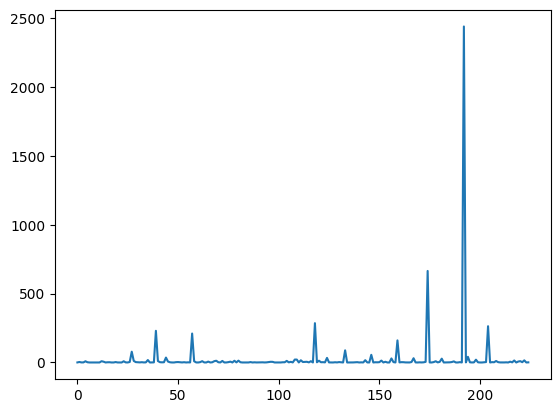

In [10]:
y_train_pred = stack.predict(X_train_np)
train_loss = ((y_train_pred - y_train_np)**2)

y_test_pred = stack.predict(X_test_np)
test_loss = ((y_test_pred - y_test_np)**2)
max(train_loss)**(1/2), max(test_loss)

criterion = nn.MSELoss()
train_loss_mean = criterion(torch.tensor(y_train_pred), torch.tensor(np.array(y_train_np)))
test_loss_mean = criterion(torch.tensor(y_test_pred), torch.tensor(np.array(y_test_np)))
print(train_loss_mean, test_loss_mean, max(test_loss))

plt.plot(list(test_loss))

### Validate

In [ ]:
import pickle
# trained model from ~
with open("result/updated_models_first.pk", "rb") as f:
    model_history = pickle.load(f)
# the final model for the algo
model = model_history[list(model_history.keys())[-1]]['reorg']

In [5]:
# validate
train_output = model(X_train)
train_loss = criterion(train_output, y_train.reshape(-1, 1))

test_output = model(X_test)
test_loss = criterion(test_output, y_test.reshape(-1, 1))

train_loss, test_loss

(tensor(0.6482, device='cuda:0', dtype=torch.float64,
        grad_fn=<MseLossBackward0>),
 tensor(55.7283, device='cuda:0', dtype=torch.float64,
        grad_fn=<MseLossBackward0>))

In [11]:
train_resid = (y_train.cpu().detach().numpy() - train_output.cpu().detach().numpy())**2
test_resid = (y_test.cpu().detach().numpy() - test_output.cpu().detach().numpy())**2
# test_resid = test_resid[test_resid != np.max(test_resid)]
np.max(train_resid), learning_goal**2, max(test_resid)

(4.1934333975694384,
 tensor(4.2025, device='cuda:0', dtype=torch.float64),
 array([6246.97232542]))

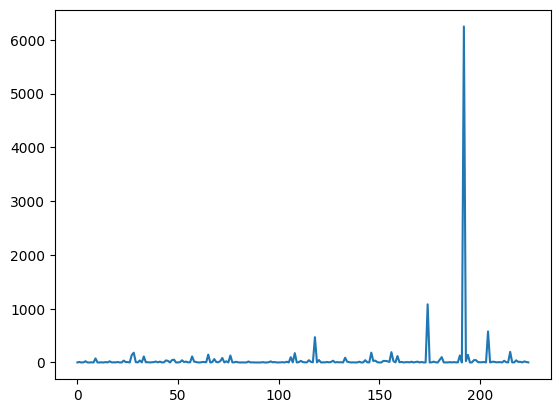

In [7]:
# plt.plot(train_resid)
plt.plot(test_resid)

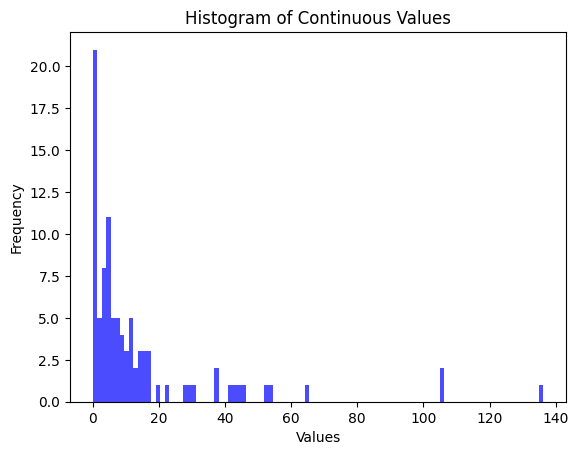

tensor([136.2709], dtype=torch.float64, grad_fn=<UnbindBackward0>)

In [86]:
# check residuals

# Example tensor with continuous values
resid_train = torch.square(model(X_train) - y_train)
resid_test = torch.square(model(X_test) - y_test)

# Plot the histogram
plt.hist(resid_test.detach().numpy(), bins=100, color='blue', alpha=0.7)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Continuous Values')
plt.show()
torch.var(resid_test)

max(resid_test)